In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import statistics


In [225]:
position = ["position_x","position_y","position_z"]
target= ["target_position_x","target_position_y","target_position_z"]
total_time = "time"

max_distance_error = 4.0

max_height_error = 3*max_distance_error/4
max_contraction_error = 1.0
feedback_types = ['Visual', 'Glove', 'Bracelets']
task_types = ["time", "1st_waypoint_time", "2nd_waypoint_time", "3rd_waypoint_time", "extension_time", "contraction_time"]
error_types = ["height_error", "x_error", "z_error", "extension_error"]
#position_x,position_y,position_z,target_position_x,target_position_y,target_position_z,time,extension,target_extension,height_error,distance_to_waypoint,extension_error,reaching_height_time

In [3]:
os.getcwd()
os.chdir('..\Bidirectional_interface\Assets\Logs')



In [4]:
folders = ['Raw', 'Visual', 'Glove', 'Bracelets']
for folder in folders:
    try:
        os.mkdir(folder)
    except:
        print("Folder", folder, "already existing")

Folder Raw already existing
Folder Visual already existing
Folder Glove already existing
Folder Bracelets already existing


In [5]:
def get_contraction_time(file):
    data = pd.read_csv(file)
    index = next(i for i, j in enumerate(data['3rd_waypoint_time'].to_list()) if j)
    data['contraction_time'].iloc[-1] =  data['time'].iloc[-1] - data['time'][index]
    data.to_csv(file)



In [6]:
d = os.listdir('Visual')
d

['1_14_48_sub1_Visual.csv',
 '2_13_44_sub2_Visual.csv',
 '3_29_19_sub3_Visual.csv',
 '4_27_10_sub4_Visual.csv']

In [7]:
all_mixed_files = glob.glob("*.csv")

In [8]:
def move_in_correct_folder(filename):
    if "drone" in filename :
        newfilename = "Raw" +"\\" + filename
        os.replace(filename, newfilename)    
    else:
        types_of_feedback = ["Visual", "Glove", "Bracelets"]
        for fb_type in types_of_feedback:
            if fb_type in filename :
                newfilename = fb_type +"\\" + filename
                os.replace(filename, newfilename)
                

def organise_logs(all_files):
    all_files =  glob.glob("*.csv")
    for file in all_files:  
        move_in_correct_folder(file)
    


Put the files in the correct folders

In [9]:
organise_logs(all_mixed_files)

In [10]:
def get_time(feedback_type, task_type):
    #task_type is a string: "1st_waypoint_time", "2nd_waypoint_time", "3rd_waypoint_time", "extension_time", "contraction_time", "time"
    time_list = []
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        time_list.append(data[task_type].iloc[-1])
    return time_list




In [11]:
np.std(get_time("Visual", "time"))

17.25160086504656

In [115]:
def plot_execution_time(task_type):
    title = task_type
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1,3,1)
    ax.bar([0, 1,2],
       [np.mean(get_time(feedback_types[0], task_type)), np.mean(get_time(feedback_types[1], task_type)),  np.mean(get_time(feedback_types[2], task_type))],
          yerr =[np.std(get_time(feedback_types[0], task_type)), np.std(get_time(feedback_types[1], task_type)), np.std(get_time(feedback_types[2], task_type))])

    plt.xticks(range(3),feedback_types)
#     plt.ylim([0, 20])
    plt.title(title)
    
def plot_all_execution_times():
    i = 1
    for task_type in task_types:
        
        title = task_type
        if i == 1 : fig = plt.figure(figsize=(12, 4))
            
        ax = fig.add_subplot(1,3,i)
        ax.bar([0, 1,2],
           [np.mean(get_time(feedback_types[0], task_type)), np.mean(get_time(feedback_types[1], task_type)),  np.mean(get_time(feedback_types[2], task_type))],
              yerr =[np.std(get_time(feedback_types[0], task_type)), np.std(get_time(feedback_types[1], task_type)), np.std(get_time(feedback_types[2], task_type))])

        plt.xticks(range(3),feedback_types)
    #     plt.ylim([0, 20])
        plt.title(title)
        i+=1
        if i>3: i =1
            
def plot_all_boxplot_execution_time():
    for task_type in task_types:
        plot_boxplot_execution_time(task_type)

def plot_boxplot_execution_time(task_type):
    # Define styling for each boxplot component
    medianprops = {'color': 'magenta', 'linewidth': 2}
    boxprops = {'color': 'black', 'linestyle': '-', 'linewidth':2}
    whiskerprops = {'color': 'black', 'linestyle': '-'}
    capprops = {'color': 'black', 'linestyle': '-'}
    flierprops = {'color': 'black', 'marker': 'x'}
    title = task_type
 
    fig = plt.figure()
    ax = plt.axes()

    width = 0.5
    bp = plt.boxplot([get_time(feedback_types[0], task_type), get_time(feedback_types[1], task_type), get_time(feedback_types[2], task_type)], 
                     widths = width, labels = feedback_types,medianprops=medianprops,
                       boxprops=boxprops,
                       whiskerprops=whiskerprops,
                       capprops=capprops,
                       flierprops=flierprops )


    if task_type == "time": task_type = "Total " + task_type
    plt.title(task_type)
    ax.set_xlabel('Feedback type')
    ax.set_ylabel('Time [s]')

        
        
def plot_height(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_y"])
        plt.plot(data["target_position_y"]+1)
        plt.plot(data["target_position_y"]+1+np.ones(len(data["height_error"]))*0.1*max_height_error)
        plt.plot(data["target_position_y"]+1-np.ones(len(data["height_error"]))*0.1*max_height_error)
        
        plt.title("Height")
        plt.figure()
        plt.plot(data["height_error"])
        plt.plot(np.ones(len(data["height_error"]))*0.1*max_height_error)
        plt.plot(np.ones(len(data["height_error"]))*(-0.1*max_height_error))
        plt.plot(np.zeros(len(data["height_error"])))
        
def plot_x_distance(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_x"])
        plt.plot(data["target_position_x"])
        plt.plot(data["target_position_x"]+np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        plt.plot(data["target_position_x"]-np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        
        plt.title("X distance")
        plt.figure()
        plt.plot(data["target_position_x"]- data["position_x"])
        plt.plot(np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        plt.plot(np.ones(len(data["target_position_x"]))*(-0.1*max_distance_error))
        plt.plot(np.zeros(len(data["target_position_x"])))
        
def plot_z_distance(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_z"])
        plt.plot(data["target_position_z"])
        plt.plot(data["target_position_z"]+np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        plt.plot(data["target_position_z"]-np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        
        plt.title("z distance")
        plt.figure()
        plt.plot(data["target_position_z"]- data["position_z"])
        plt.plot(np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        plt.plot(np.ones(len(data["target_position_z"]))*(-0.1*max_distance_error))
        plt.plot(np.zeros(len(data["target_position_z"])))        
        

    

In [197]:
def plot_all_sub_trajectories(information_type):
    
    
    if information_type == "extension":
        max_error = max_contraction_error
    elif information_type == "position_y":
        max_error = max_height_error
    else: max_error = max_distance_error
        
    fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(16,20))
    row = 0
    column = 0
    for feedback_type in feedback_types:
        files = glob.glob(feedback_types[column]+"\*.csv")
        row = 0
        for file in files:

            data = pd.read_csv(file)
            ax[row][column].plot(data[information_type])
            plt.title("test")
            if information_type == "position_y" : 
                ax[row][column].plot(data["target_"+information_type]+1)
                ax[row][column].plot(data["target_"+information_type]+1+np.ones(len(data["height_error"]))*0.1*max_error)
                ax[row][column].plot(data["target_"+information_type]+1-np.ones(len(data["height_error"]))*0.1*max_error)
            else:
                ax[row][column].plot(data["target_"+information_type])
                ax[row][column].plot(data["target_"+information_type]+np.ones(len(data["height_error"]))*0.1*max_error)
                ax[row][column].plot(data["target_"+information_type]-np.ones(len(data["height_error"]))*0.1*max_error)
            ax[row][column].set_title(feedback_type + " "+ information_type)
            row += 1
        column+=1

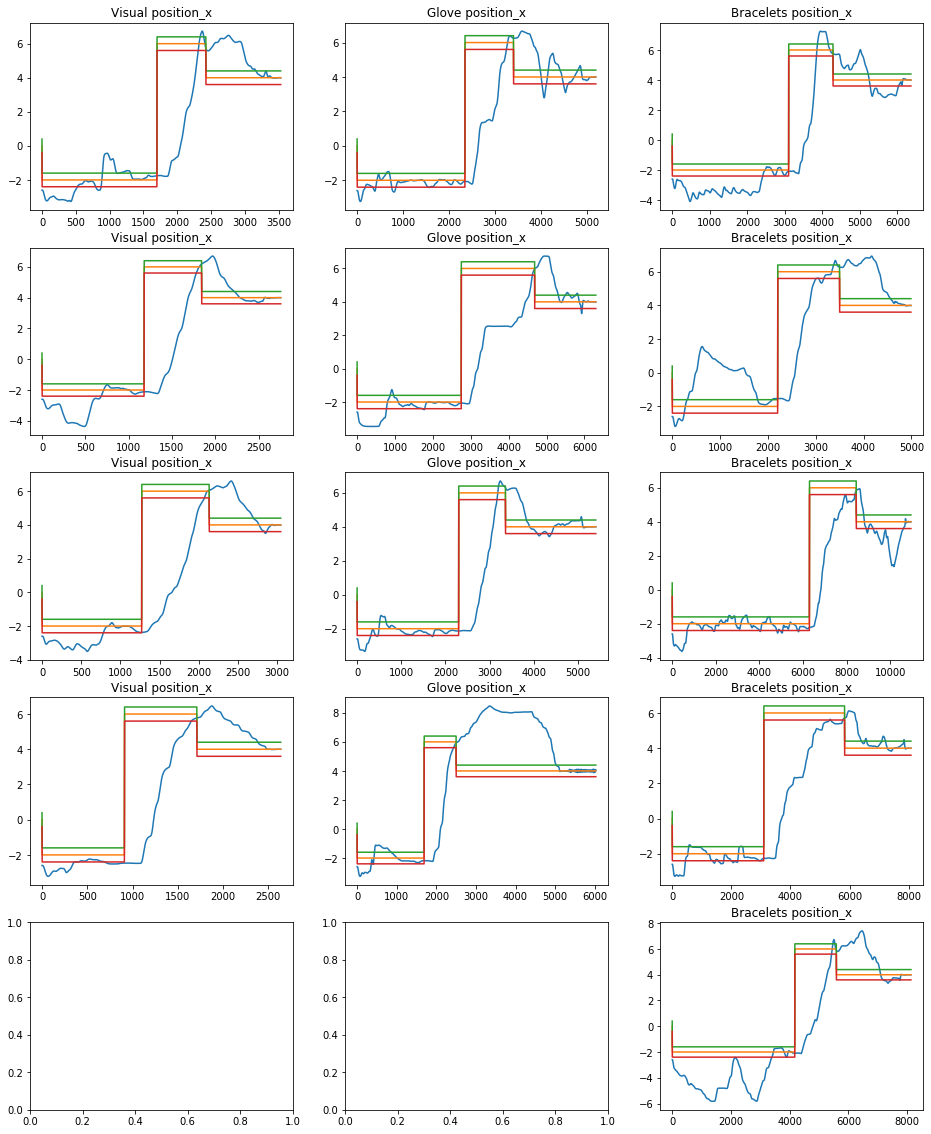

In [199]:
plot_all_sub_trajectories("position_x")

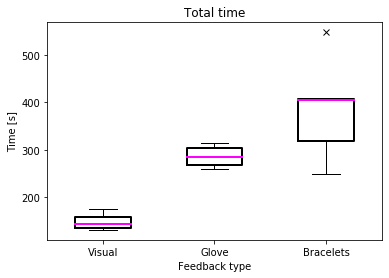

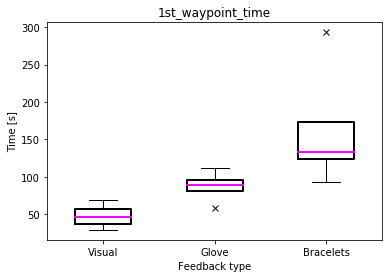

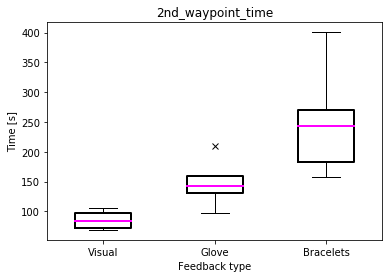

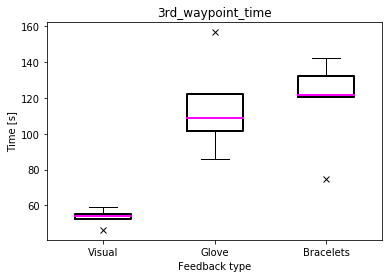

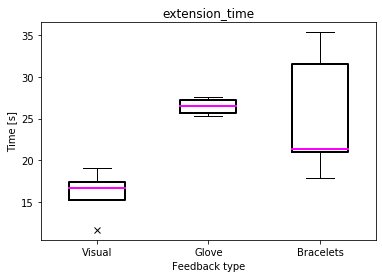

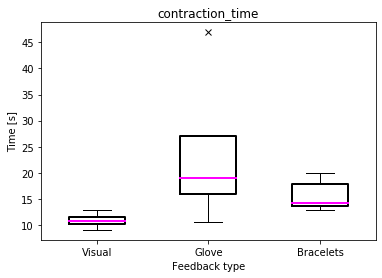

In [116]:
plot_all_boxplot_execution_time()

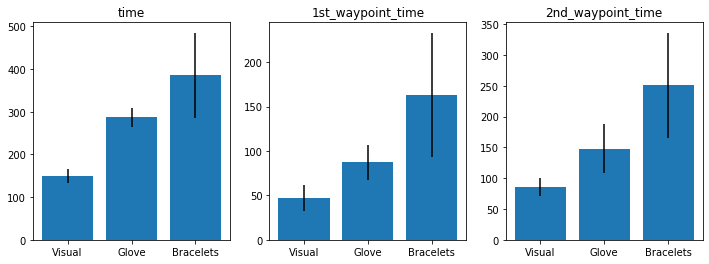

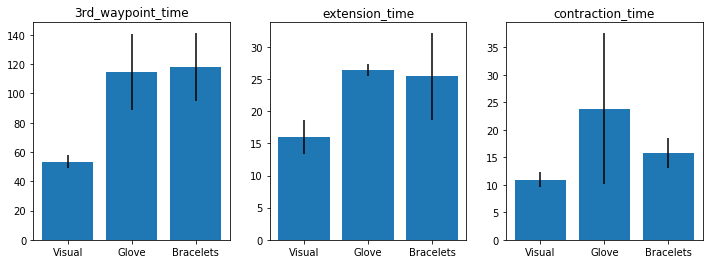

In [108]:
plot_all_execution_times()

In [14]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [222]:
def get_overshoot_count_by_type(feedback_type, error_type):
    #feedback_type : string, "Visual", "Glove", "Bracelets"
    #error_type : string, height_error, x_error, z_error, extension_error
    error_list = []
    max_error = 0
    
    overshoot_list = []
    
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        if error_type == "height_error":
            error_list = data["height_error"]
            max_error = max_height_error
        elif error_type == "x_error":
            error_list = data["target_position_x"]-data["position_x"]
            max_error = max_distance_error
        elif error_type == "z_error":
            error_list = data["target_position_y"]-data["position_y"]
            max_error = max_distance_error
        elif error_type == "extension_error":
            error_list = data["extension_error"]
            max_error = max_contraction_error
        else : 
            print("incorrect error_type")
            return
        overshoot_list.append(get_overshoot_count(error_list, max_error))
        
    return overshoot_list

def get_overshoot_count(error_list, max_error):
    wasOk = False
    overshoot_count = 0
    for point in error_list:
        if point > 0.1*max_error:
            if wasOk:
                overshoot_count += 1
                wasOk = False
        elif point < -0.1*max_error:
            if wasOk:
                overshoot_count += 1
                wasOk = False
        else: wasOk = True
    return overshoot_count-1 # - 1 because at the begining, it is not an overshoot

def get_overshoot_count_mean_and_std(feedback_type, error_type):
    #feedback_type : string, "Visual", "Glove", "Bracelets"
    #error_type : string, height_error, x_error, z_error, extension_error
    error_list = []
    max_error = 0
    
    overshoot_list = []
    
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        if error_type == "height_error":
            error_list = data["height_error"]
            max_error = max_height_error
        elif error_type == "x_error":
            error_list = data["target_position_x"]-data["position_x"]
            max_error = max_distance_error
        elif error_type == "z_error":
            error_list = data["target_position_y"]-data["position_y"]
            max_error = max_distance_error
        elif error_type == "extension_error":
            error_list = data["extension_error"]
            max_error = max_contraction_error
        else : 
            print("incorrect error_type")
            return
        overshoot_list.append(get_overshoot_count(error_list, max_error))
        
    return [np.mean(np.asarray(overshoot_list)), np.std(np.asarray(overshoot_list))]

def plot_overshoot( error_type):    
    mean_and_std_list =[ get_overshoot_count_mean_and_std(feedback_type, error_type) for feedback_type in feedback_types]
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1,3,1)
    ax.bar([0, 1,2],
       [mean_and_std_list[0][0], mean_and_std_list[1][0], mean_and_std_list[2][0]],
          yerr =[mean_and_std_list[0][1], mean_and_std_list[1][1], mean_and_std_list[2][1]])

    plt.xticks(range(3),feedback_types)
    plt.ylim([0, 20])
    plt.title('Nb of overshoot for '+ error_type)
    

def plot_all_overshoot():
    i = 1
    for error_type in error_types:
        mean_and_std_list =[get_overshoot_count_mean_and_std(feedback_type, error_type) for feedback_type in feedback_types]
        if i == 1:    fig = plt.figure(figsize=(12, 4))

        ax = fig.add_subplot(1, 3, i)
        ax.bar([0, 1,2],
           [mean_and_std_list[0][0], mean_and_std_list[1][0], mean_and_std_list[2][0]],
              yerr =[mean_and_std_list[0][1], mean_and_std_list[1][1], mean_and_std_list[2][1]])

        plt.xticks(range(3),feedback_types)
        plt.ylim([0, 20])
        plt.title('Nb of overshoot for '+ error_type)    
        i+=1
        if i > 3 : i = 1

def plot_overshoot_boxplot(error_type):
    medianprops = {'color': 'magenta', 'linewidth': 2}
    boxprops = {'color': 'black', 'linestyle': '-', 'linewidth':2}
    whiskerprops = {'color': 'black', 'linestyle': '-'}
    capprops = {'color': 'black', 'linestyle': '-'}
    flierprops = {'color': 'black', 'marker': 'x'}
    title = error_type
 
    fig = plt.figure()
    ax = plt.axes()

    width = 0.5
    bp = plt.boxplot([get_overshoot_count_by_type(feedback_types[0], error_type), get_overshoot_count_by_type(feedback_types[1], error_type), get_overshoot_count_by_type(feedback_types[2], error_type)], 
                     widths = width, labels = feedback_types,medianprops=medianprops,
                       boxprops=boxprops,
                       whiskerprops=whiskerprops,
                       capprops=capprops,
                       flierprops=flierprops )


    plt.title(title)
    ax.set_xlabel('Feedback type')
    ax.set_ylabel('Time [s]')
    
def plot_all_overshoot_boxplot():
    for error_type in error_types :
        plot_overshoot_boxplot(error_type)


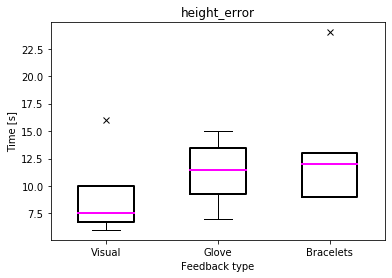

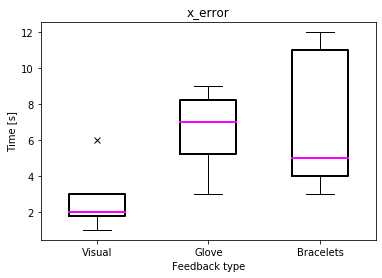

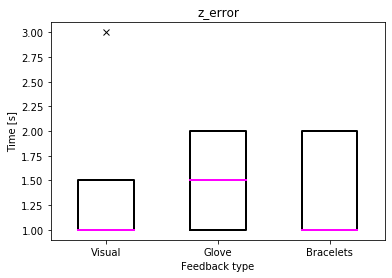

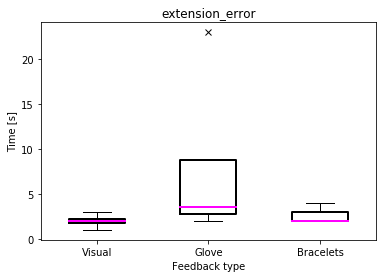

In [227]:
plot_all_overshoot_boxplot()

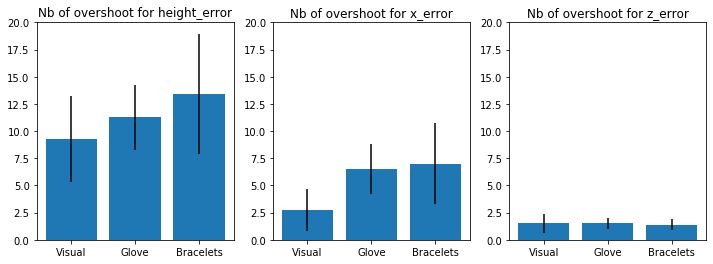

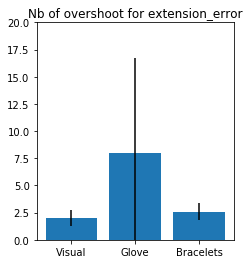

In [226]:
plot_all_overshoot()


In [ ]:
plot_overshoot("z_error")

In [ ]:
data = pd.read_csv("Visual\\1_14_48_sub1_Visual.csv") 

In [ ]:
get_overshoot_count(data["height_error"], max_height_error)

In [ ]:
plot_overshoot("height_error")

In [ ]:
get_overshoot_count_mean_and_std("Bracelets", "height_error")

In [ ]:
_,_,test = get_mean_and_std_times(visual_waypoint_times)
for t in test:
    print (t)

In [ ]:
get_mean_and_std_times(visual_total_time)

In [ ]:
mean, stddev = get_mean_and_std_times(visual_waypoint_times)
stddev

In [ ]:
visual_extraction_contraction_times


In [ ]:
get_mean_and_std_times(visual_extraction_contraction_times)

In [ ]:
get_mean_and_std_times(glove_total_time)

In [ ]:
get_mean_and_std_times(glove_extraction_contraction_times)

In [ ]:
get_mean_and_std_times(glove_waypoint_times)

In [ ]:
plt.plot(t,data['position_x'])
plt.plot(t, data['position_y'])
plt.plot(t, data['position_z'])

In [ ]:
plt.plot(data['time'])


In [ ]:
for x in list(data):
    plt.figure()
    plt.plot(data[x])
    plt.title(x)